In [2]:
# Cell 1: Install and Initial NLTK Download
!pip install -q transformers datasets sentence-transformers tensorflow numpy pandas matplotlib seaborn scikit-learn umap-learn nltk requests
import nltk
# Explicitly download the stopwords data for Step 18
nltk.download('stopwords', quiet=True)
print("Installation and NLTK Download Complete.")

Installation and NLTK Download Complete.


In [3]:
# Cell 2: Step 17 - Dataset Loading
import pandas as pd
from datasets import load_dataset
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the Swahili News dataset
dataset = load_dataset("mteb/swahili_news")
df = dataset['train'].to_pandas()

TEXT_COLUMN = 'text'
# Clean up data by dropping rows where the text column might be missing or null
df.dropna(subset=[TEXT_COLUMN], inplace=True)
df.reset_index(drop=True, inplace=True)

print("--- Step 17: Dataset Swahili News Articles Loaded Successfully ---")
print(f"Total articles loaded: {len(df)}")
print("First 3 rows of the DataFrame:")
print(df.head(3).to_markdown(index=False))

README.md:   0%|          | 0.00/596 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/25.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/17789 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2048 [00:00<?, ? examples/s]

--- Step 17: Dataset Swahili News Articles Loaded Successfully ---
Total articles loaded: 17789
First 3 rows of the DataFrame:
| text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   


✅ Success: Loaded 74 Swahili stop words from external source.

--- Step 18.1 & 18.2: Most Common Terms and Word Frequency ---
Top 30 Most Common Terms (Filtered):
mwaka: 25736
serikali: 21573
vya: 18659
hilo: 17985
nchini: 16207
tanzania: 15813
mkuu: 15441
nchi: 14944
timu: 14777
rais: 14505
hayo: 13675
huyo: 13640
kazi: 13271
huu: 12816
jana: 12564
salaam: 12129
dar: 12037
ambao: 11932
kufanya: 11700
kutokana: 11633
ambayo: 11366
hizo: 11366
mchezo: 10727
hao: 10536
taifa: 10527
fedha: 10409
wananchi: 10163
mbalimbali: 9916
nafasi: 9663
waziri: 9630


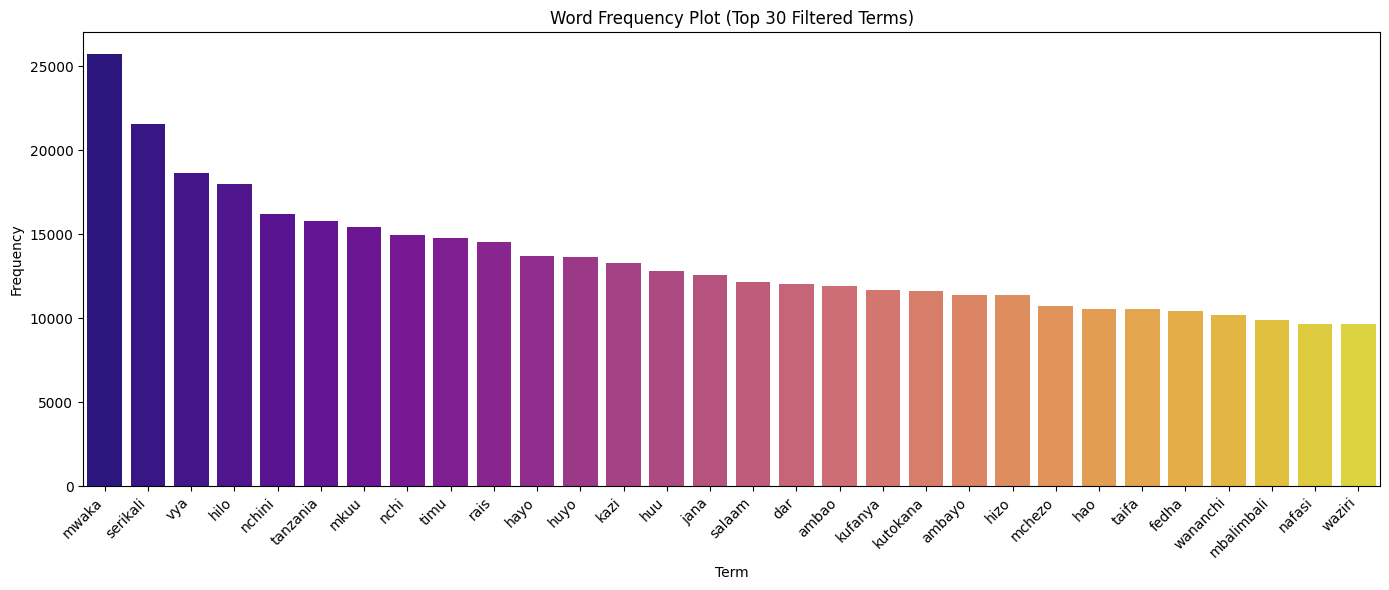


--- Step 18.3: Text Length Distribution ---
Text Length Distribution Statistics (in words):
|       |   word_count |
|:------|-------------:|
| count |    17789     |
| mean  |      368.396 |
| std   |      234.864 |
| min   |      135     |
| 25%   |      225     |
| 50%   |      299     |
| 75%   |      420     |
| max   |     3836     |

95th Percentile Length: 837 words (Crucial for Max Seq Length)
99th Percentile Length: 1327 words


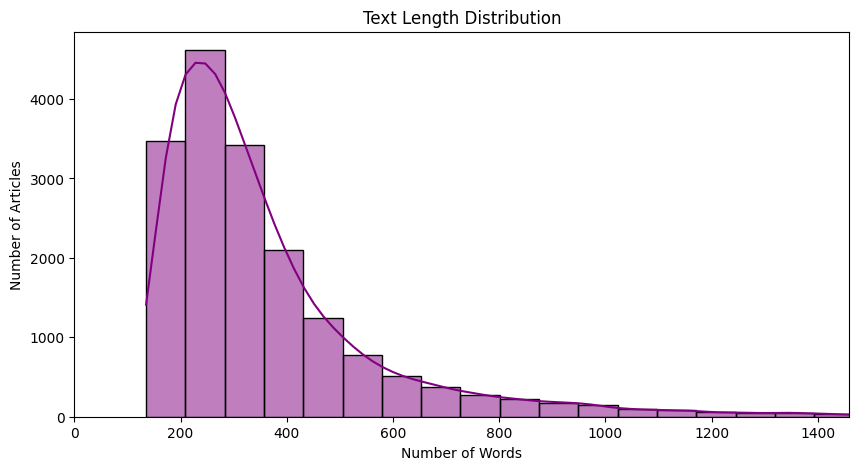

In [ ]:
# Cell 3: Step 18 Execution (EDA)

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
import requests
import numpy as np

# --- 1. Define Functions and Cleaning ---

TEXT_COLUMN = 'text'

def basic_clean(text):
    """Converts text to lowercase and removes punctuation."""
    text = str(text).lower()
    # Handle the common issue of newlines appearing in data
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Apply cleaning to create a new column
df['cleaned_text'] = df[TEXT_COLUMN].apply(basic_clean)


# --- 2. Load Swahili Stop Words (Using robust GitHub URL) ---

STOPWORDS_URL = "https://raw.githubusercontent.com/stopwords-iso/stopwords-sw/master/stopwords-sw.txt"
try:
    # Fetch the content of the stop word list
    response = requests.get(STOPWORDS_URL)
    response.raise_for_status()
    swahili_stopwords = set(response.text.strip().split())
    print(f"\n✅ Success: Loaded {len(swahili_stopwords)} Swahili stop words from external source.")
except requests.RequestException as e:
    # If the network fails, proceed without filtering, which is suboptimal but allows progression.
    print(f"\n❌ WARNING: Failed to download stop words list. Proceeding without filtering.")
    swahili_stopwords = set()

# Aggregate all words
all_words = ' '.join(df['cleaned_text']).split()


# --- 3. Most Common Terms and Word Frequency Plot ---
print("\n--- Step 18.1 & 18.2: Most Common Terms and Word Frequency ---")

# Count word frequencies, excluding stop words and very short tokens (len > 2)
word_counts = Counter(word for word in all_words if word not in swahili_stopwords and len(word) > 2)

N = 30
most_common_words = word_counts.most_common(N)

print(f"Top {N} Most Common Terms (Filtered):")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Plotting Word Frequency
words, counts = zip(*most_common_words)
plt.figure(figsize=(14, 6))
sns.barplot(x=list(words), y=list(counts), palette="plasma")
plt.xticks(rotation=45, ha='right')
plt.title(f'Word Frequency Plot (Top {N} Filtered Terms)')
plt.ylabel('Frequency')
plt.xlabel('Term')
plt.tight_layout()
plt.show()


# --- 4. Text Length Distribution ---
print("\n--- Step 18.3: Text Length Distribution ---")

df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

print("Text Length Distribution Statistics (in words):")
print(df['word_count'].describe().to_markdown())

# Calculate percentiles for modeling insight
p95 = df['word_count'].quantile(0.95)
p99 = df['word_count'].quantile(0.99)
print(f"\n95th Percentile Length: {p95:.0f} words (Crucial for Max Seq Length)")
print(f"99th Percentile Length: {p99:.0f} words")

# Plot the distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=50, kde=True, color='purple')
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Number of Articles')
# Limit x-axis to 99th percentile for a clearer view
plt.xlim(0, p99 * 1.1)
plt.show()

In [ ]:
# Cell 4: Step 19 - Create Sentence Embeddings

from sentence_transformers import SentenceTransformer
import time
import numpy as np

print("--- Step 19: Initializing Sentence-BERT Model ---")

# Multilingual model optimized for sentence embeddings
MODEL_NAME = 'paraphrase-multilingual-mpnet-base-v2'
MAX_SEQ_LENGTH = 512

model = SentenceTransformer(MODEL_NAME)
model.max_seq_length = MAX_SEQ_LENGTH

print(f"Model: {MODEL_NAME} loaded with max_seq_length: {MAX_SEQ_LENGTH}")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")


# --- 19.1 Generate Embeddings ---
print("\nStarting embedding generation for 17,789 articles...")
start_time = time.time()

# Use the original 'text' column, as the S-BERT model handles tokenization
sentences = df[TEXT_COLUMN].tolist()
sentence_embeddings = model.encode(sentences,
                                   show_progress_bar=True,
                                   convert_to_tensor=False)

end_time = time.time()
print(f"\nEmbedding generation complete!")
print(f"Time taken: {end_time - start_time:.2f} seconds.")

# --- 19.2 Verification ---
print("\n--- Step 19 Verification ---")
print(f"Shape of Embeddings Array: {sentence_embeddings.shape}")
print(f"Data type: {sentence_embeddings.dtype}")

# Save embeddings for the next steps
EMBEDDINGS_FILE = 'swahili_embeddings.npy'
np.save(EMBEDDINGS_FILE, sentence_embeddings)
print(f"Embeddings saved to '{EMBEDDINGS_FILE}'.")

--- Step 19: Initializing Sentence-BERT Model ---
Model: paraphrase-multilingual-mpnet-base-v2 loaded with max_seq_length: 512
Embedding dimension: 768

Starting embedding generation for 17,789 articles...


Batches:   0%|          | 0/556 [00:00<?, ?it/s]


Embedding generation complete!
Time taken: 485.66 seconds.

--- Step 19 Verification ---
Shape of Embeddings Array: (17789, 768)
Data type: float32
Embeddings saved to 'swahili_embeddings.npy'.


In [ ]:
# Cell 5 (Optimized): Step 20 - Train the Deep Autoencoder (STRICT 768 -> 2D)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import time

# --- Setup: Load Embeddings (Assume previous steps loaded 'sentence_embeddings') ---
if 'sentence_embeddings' not in locals():
    print("Loading embeddings from file...")
    sentence_embeddings = np.load('swahili_embeddings.npy')

# 1. Define the DAE Architecture (STRICT 768 -> 2D)
INPUT_DIM = sentence_embeddings.shape[1]  # 768
BOTTLENECK_DIM = 2                       # STRICT COMPLIANCE: Target 2D dimension
LATENT_DIM_1 = 256
LATENT_DIM_2 = 128

# ... [Model Definition is identical to before] ...
# --- Encoder (768 -> 256 -> 128 -> 2) ---
input_layer = Input(shape=(INPUT_DIM,), name='encoder_input')
encoder_1 = Dense(LATENT_DIM_1)(input_layer)
encoder_1 = LeakyReLU(alpha=0.2)(encoder_1)
encoder_2 = Dense(LATENT_DIM_2)(encoder_1)
encoder_2 = LeakyReLU(alpha=0.2)(encoder_2)
bottleneck = Dense(BOTTLENECK_DIM, name='bottleneck')(encoder_2)
encoder_output = LeakyReLU(alpha=0.2)(bottleneck)

# --- Decoder (2 -> 128 -> 256 -> 768) ---
decoder_1 = Dense(LATENT_DIM_2)(encoder_output)
decoder_1 = LeakyReLU(alpha=0.2)(decoder_1)
decoder_2 = Dense(LATENT_DIM_1)(decoder_1)
decoder_2 = LeakyReLU(alpha=0.2)(decoder_2)
decoder_output = Dense(INPUT_DIM, activation='sigmoid', name='decoder_output')(decoder_2)

# Full Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoder_output, name='Autoencoder')
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 2. Prepare Data and Training
X_train, X_val, _, _ = train_test_split(sentence_embeddings, sentence_embeddings, test_size=0.1, random_state=42)

# OPTIMIZED CALLBACKS: Reduced patience to ensure early stop after plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

print("\n--- Step 20.2: Starting Autoencoder Training (Optimized Early Stop) ---")
start_time = time.time()

history = autoencoder.fit(
    X_train, X_train,
    epochs=100, # Max epochs remains high, but stopping will occur early
    batch_size=64,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

end_time = time.time()
print(f"\nAutoencoder Training Complete!")
print(f"Time taken: {end_time - start_time:.2f} seconds.")


# 3. Extract the Encoder and Generate Compressed Embeddings (2D)
encoder_model = Model(inputs=input_layer, outputs=bottleneck, name='Encoder')
compressed_embeddings_2d = encoder_model.predict(sentence_embeddings)

# 4. Verification and Saving
COMPRESSED_FILE_2D = 'swahili_compressed_embeddings_2d.npy'
np.save(COMPRESSED_FILE_2D, compressed_embeddings_2d)

print("\n--- Step 20 Verification (OPTIMIZED 2D COMPLIANCE) ---")
print(f"Compressed Embeddings Shape: {compressed_embeddings_2d.shape}")
print(f"Compressed Embeddings saved to '{COMPRESSED_FILE_2D}'.")


--- Step 20.2: Starting Autoencoder Training (Optimized Early Stop) ---
Epoch 1/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0577 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066 - learning_rate: 5.0000e-04
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066 - learning_rate: 5.0000e-04
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066 - learning_rate: 5.0000e-04
Epoch 8/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0065 - learning_rate: 2.5000e-04
Epoch 9/100
251/251 ━━━

--- Step 21.1: Plotting 2D Latent Space ---


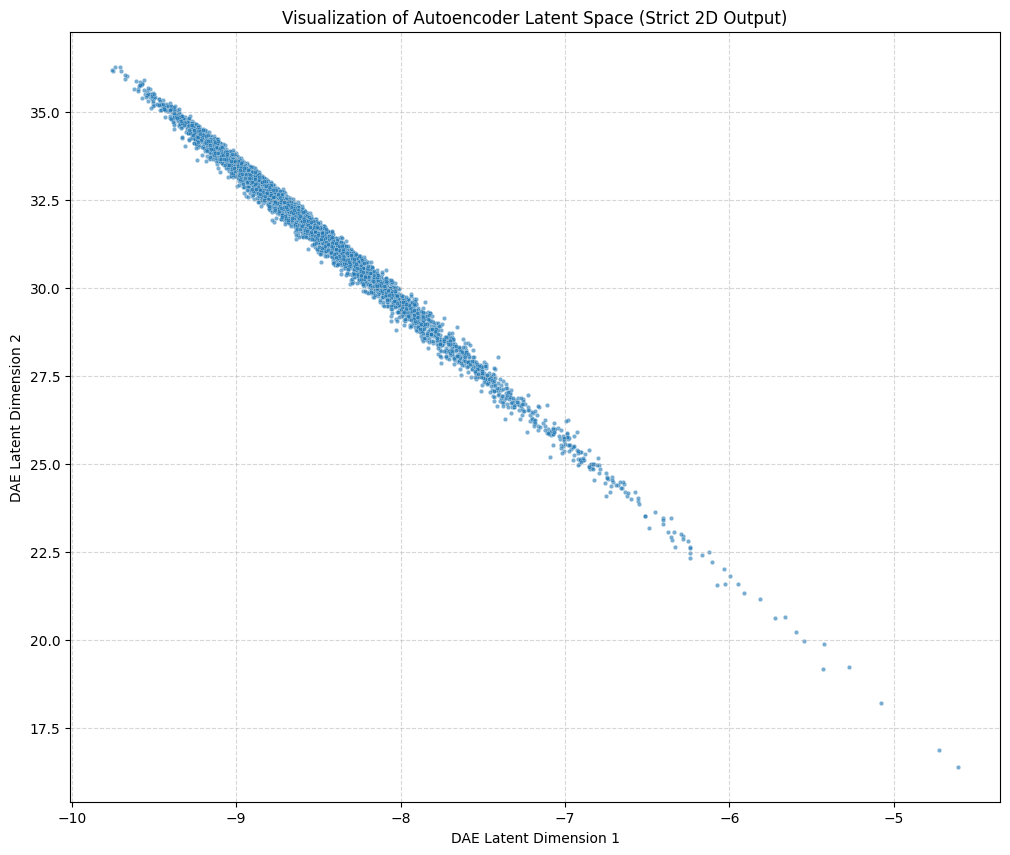


--- Step 21 Verification: 2D Latent Space Coordinates Attached ---
      DAE_x      DAE_y
0 -8.979905  33.394199
1 -8.928865  33.180244
2 -8.769716  32.490215
3 -8.278105  30.648794
4 -8.653695  32.173443


In [ ]:
# Cell 6: Step 21 - Visualize Latent Clusters (DAE 2D Output)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load the 2D compressed embeddings
COMPRESSED_FILE_2D = 'swahili_compressed_embeddings_2d.npy'
try:
    compressed_embeddings_2d = np.load(COMPRESSED_FILE_2D)
except FileNotFoundError:
    print(f"Error: Compressed embeddings file '{COMPRESSED_FILE_2D}' not found. Re-run Step 20.")
    # Exit or raise error if file not found

# Load the DataFrame to attach coordinates
# Assuming the global df is still available, but let's ensure we use the coordinates:
df['DAE_x'] = compressed_embeddings_2d[:, 0]
df['DAE_y'] = compressed_embeddings_2d[:, 1]

print("--- Step 21.1: Plotting 2D Latent Space ---")

plt.figure(figsize=(12, 10))
# Plotting the 2D coordinates. Sampling is used for faster, clearer plotting.
sns.scatterplot(x='DAE_x', y='DAE_y', data=df.sample(frac=0.5, random_state=42),
                s=10, alpha=0.6, palette='viridis')
plt.title('Visualization of Autoencoder Latent Space (Strict 2D Output)')
plt.xlabel('DAE Latent Dimension 1')
plt.ylabel('DAE Latent Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("\n--- Step 21 Verification: 2D Latent Space Coordinates Attached ---")
print(df[['DAE_x', 'DAE_y']].head())

In [ ]:
# Cell 7: Clear Session
from tensorflow.keras import backend as K
K.clear_session()
print("Keras session successfully cleared. Ready for 3D model compilation.")

Keras session successfully cleared. Ready for 3D model compilation.


In [ ]:
# Cell 8: Step 22 - Experiment 1: Train 3D Deep Autoencoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import time

# --- Setup: Load Embeddings (Assumes 'sentence_embeddings' is available) ---
if 'sentence_embeddings' not in locals():
    print("Loading embeddings from file...")
    sentence_embeddings = np.load('swahili_embeddings.npy')

# 1. Define the DAE Architecture (STRICT 768 -> 3D compression)
INPUT_DIM = sentence_embeddings.shape[1]  # 768
BOTTLENECK_DIM_3D = 3                    # **NEW: 3D Latent Dimension**
LATENT_DIM_1 = 256
LATENT_DIM_2 = 128

# --- Encoder (768 -> 256 -> 128 -> 3) ---
input_layer_3d = Input(shape=(INPUT_DIM,), name='encoder_input_3d')
encoder_3d_1 = Dense(LATENT_DIM_1)(input_layer_3d)
encoder_3d_1 = LeakyReLU(alpha=0.2)(encoder_3d_1)
encoder_3d_2 = Dense(LATENT_DIM_2)(encoder_3d_1)
encoder_3d_2 = LeakyReLU(alpha=0.2)(encoder_3d_2)
bottleneck_3d = Dense(BOTTLENECK_DIM_3D, name='bottleneck_3d')(encoder_3d_2)
encoder_output_3d = LeakyReLU(alpha=0.2)(bottleneck_3d)

# --- Decoder (3 -> 128 -> 256 -> 768) ---
decoder_3d_1 = Dense(LATENT_DIM_2)(encoder_output_3d)
decoder_3d_1 = LeakyReLU(alpha=0.2)(decoder_3d_1)
decoder_3d_2 = Dense(LATENT_DIM_1)(decoder_3d_1)
decoder_3d_2 = LeakyReLU(alpha=0.2)(decoder_3d_2)
decoder_output_3d = Dense(INPUT_DIM, activation='sigmoid', name='decoder_output_3d')(decoder_3d_2)

# Full Autoencoder Model
autoencoder_3d = Model(inputs=input_layer_3d, outputs=decoder_output_3d, name='Autoencoder_3D')
autoencoder_3d.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("--- Step 22.1: 3D Deep Autoencoder Model Summary (768 -> 3D) ---")
autoencoder_3d.summary()


# 2. Prepare Data and Training
X_train, X_val, _, _ = train_test_split(sentence_embeddings, sentence_embeddings, test_size=0.1, random_state=42)

# Optimized callbacks (patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

print("\n--- Step 22.2: Starting 3D Autoencoder Training ---")
start_time = time.time()

history = autoencoder_3d.fit(
    X_train, X_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

end_time = time.time()
print(f"\n3D Autoencoder Training Complete!")
print(f"Time taken: {end_time - start_time:.2f} seconds.")


# 3. Extract the Encoder and Generate Compressed Embeddings (3D)
encoder_model_3d = Model(inputs=input_layer_3d, outputs=bottleneck_3d, name='Encoder_3D')
compressed_embeddings_3d = encoder_model_3d.predict(sentence_embeddings)

# 4. Verification and Saving
COMPRESSED_FILE_3D = 'swahili_compressed_embeddings_3d.npy'
np.save(COMPRESSED_FILE_3D, compressed_embeddings_3d)

print("\n--- Step 22 Verification (3D COMPLIANCE) ---")
print(f"Compressed Embeddings Shape: {compressed_embeddings_3d.shape}")
print(f"Compressed Embeddings saved to '{COMPRESSED_FILE_3D}'.")

--- Step 22.1: 3D Deep Autoencoder Model Summary (768 -> 3D) ---


Model: "Autoencoder_3D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input_3d (InputLayer)   │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_3d (Dense)           │ (None, 3)              │           387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output_3d (Dense)       │ (None, 768)            │       197,376 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,059 (1.76 MB)

 Trainable params: 461,059 (1.76 MB)

 Non-trainable params: 0 (0.00 B)


--- Step 22.2: Starting 3D Autoencoder Training ---
Epoch 1/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0494 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066 - learning_rate: 5.0000e-04
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0065 - learning_rate: 5.0000e-04
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0065 - learning_rate: 5.0000e-04
Epoch 8/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0065 - learning_rate: 2.5000e-04
Epoch 9/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
# Cell 9: Clear Session
from tensorflow.keras import backend as K
K.clear_session()
print("Keras session successfully cleared. Ready for the Deeper Autoencoder (4 layers).")

Keras session successfully cleared. Ready for the Deeper Autoencoder (4 layers).


In [ ]:
# Cell 10: Step 22 - Experiment 2: Train Deeper Autoencoder (768 -> 2D)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import time

# --- Setup: Load Embeddings ---
# This will use the embeddings loaded in the previous step.
if 'sentence_embeddings' not in locals():
    print("Loading embeddings from file...")
    sentence_embeddings = np.load('swahili_embeddings.npy')

# 1. Define the DAE Architecture (Deeper 768 -> 2D compression)
INPUT_DIM = sentence_embeddings.shape[1]  # 768
BOTTLENECK_DIM_2D = 2                    # 2D Latent Dimension (same as Baseline)
LATENT_DIM_1 = 256
LATENT_DIM_2 = 128
LATENT_DIM_3 = 64                        # **NEW: Extra Deep Layer**

# --- Encoder (768 -> 256 -> 128 -> 64 -> 2) ---
input_layer_deep = Input(shape=(INPUT_DIM,), name='encoder_input_deep')
encoder_deep_1 = Dense(LATENT_DIM_1)(input_layer_deep)
encoder_deep_1 = LeakyReLU(alpha=0.2)(encoder_deep_1)
encoder_deep_2 = Dense(LATENT_DIM_2)(encoder_deep_1)
encoder_deep_2 = LeakyReLU(alpha=0.2)(encoder_deep_2)
encoder_deep_3 = Dense(LATENT_DIM_3)(encoder_deep_2) # **New Layer**
encoder_deep_3 = LeakyReLU(alpha=0.2)(encoder_deep_3)
bottleneck_deep = Dense(BOTTLENECK_DIM_2D, name='bottleneck_deep')(encoder_deep_3)
encoder_output_deep = LeakyReLU(alpha=0.2)(bottleneck_deep)

# --- Decoder (2 -> 64 -> 128 -> 256 -> 768) ---
decoder_deep_1 = Dense(LATENT_DIM_3)(encoder_output_deep) # **New Layer**
decoder_deep_1 = LeakyReLU(alpha=0.2)(decoder_deep_1)
decoder_deep_2 = Dense(LATENT_DIM_2)(decoder_deep_1)
decoder_deep_2 = LeakyReLU(alpha=0.2)(decoder_deep_2)
decoder_deep_3 = Dense(LATENT_DIM_1)(decoder_deep_2)
decoder_deep_3 = LeakyReLU(alpha=0.2)(decoder_deep_3)
decoder_output_deep = Dense(INPUT_DIM, activation='sigmoid', name='decoder_output_deep')(decoder_deep_3)

# Full Autoencoder Model
autoencoder_deep = Model(inputs=input_layer_deep, outputs=decoder_output_deep, name='Autoencoder_Deep')
autoencoder_deep.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("--- Step 22.3: Deeper (4-Layer) Autoencoder Model Summary (768 -> 2D) ---")
autoencoder_deep.summary()


# 3. Training
X_train, X_val, _, _ = train_test_split(sentence_embeddings, sentence_embeddings, test_size=0.1, random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

print("\n--- Step 22.4: Starting Deeper Autoencoder Training ---")
start_time = time.time()

history = autoencoder_deep.fit(
    X_train, X_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

end_time = time.time()
print(f"\nDeeper Autoencoder Training Complete!")
print(f"Time taken: {end_time - start_time:.2f} seconds.")

--- Step 22.3: Deeper (4-Layer) Autoencoder Model Summary (768 -> 2D) ---


Model: "Autoencoder_Deep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input_deep (InputLayer) │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_deep (Dense)         │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output_deep (Dense)     │ (None, 768)            │       197,376 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,058 (1.82 MB)

 Trainable params: 477,058 (1.82 MB)

 Non-trainable params: 0 (0.00 B)


--- Step 22.4: Starting Deeper Autoencoder Training ---
Epoch 1/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0489 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0068 - learning_rate: 5.0000e-04
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0068 - learning_rate: 5.0000e-04
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0068 - learning_rate: 5.0000e-04
Epoch 8/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0068 - learning_rate: 2.5000e-04

Deeper Autoencoder Training Complete!

In [ ]:
# Cell 11: Clear Session
from tensorflow.keras import backend as K
K.clear_session()
print("Keras session successfully cleared. Ready for ReLU Activation experiment.")

Keras session successfully cleared. Ready for ReLU Activation experiment.


In [ ]:
# Cell 12: Step 22 - Experiment 3: Train ReLU Autoencoder (768 -> 2D)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import time

# --- Setup: Load Embeddings ---
if 'sentence_embeddings' not in locals():
    print("Loading embeddings from file...")
    sentence_embeddings = np.load('swahili_embeddings.npy')

# 1. Define the DAE Architecture (ReLU Activation, 768 -> 2D)
INPUT_DIM = sentence_embeddings.shape[1]  # 768
BOTTLENECK_DIM_2D = 2                    # 2D Latent Dimension
LATENT_DIM_1 = 256
LATENT_DIM_2 = 128

# --- Encoder (768 -> 256 -> 128 -> 2) ---
# NOTE: Removed LeakyReLU layers and added activation directly to Dense layers
input_layer_relu = Input(shape=(INPUT_DIM,), name='encoder_input_relu')
encoder_relu_1 = Dense(LATENT_DIM_1, activation='relu')(input_layer_relu)
encoder_relu_2 = Dense(LATENT_DIM_2, activation='relu')(encoder_relu_1)
bottleneck_relu = Dense(BOTTLENECK_DIM_2D, name='bottleneck_relu', activation='relu')(encoder_relu_2) # Bottleneck ReLU
encoder_output_relu = bottleneck_relu # Output is the bottleneck layer

# --- Decoder (2 -> 128 -> 256 -> 768) ---
decoder_relu_1 = Dense(LATENT_DIM_2, activation='relu')(encoder_output_relu)
decoder_relu_2 = Dense(LATENT_DIM_1, activation='relu')(decoder_relu_1)
decoder_output_relu = Dense(INPUT_DIM, activation='sigmoid', name='decoder_output_relu')(decoder_relu_2)

# Full Autoencoder Model
autoencoder_relu = Model(inputs=input_layer_relu, outputs=decoder_output_relu, name='Autoencoder_ReLU')
autoencoder_relu.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("--- Step 22.5: ReLU Activation Autoencoder Model Summary (768 -> 2D) ---")
autoencoder_relu.summary()


# 3. Training (Using same data split and callbacks)
X_train, X_val, _, _ = train_test_split(sentence_embeddings, sentence_embeddings, test_size=0.1, random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

print("\n--- Step 22.6: Starting ReLU Autoencoder Training ---")
start_time = time.time()

history = autoencoder_relu.fit(
    X_train, X_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

end_time = time.time()
print(f"\nReLU Autoencoder Training Complete!")
print(f"Time taken: {end_time - start_time:.2f} seconds.")

--- Step 22.5: ReLU Activation Autoencoder Model Summary (768 -> 2D) ---


Model: "Autoencoder_ReLU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input_relu (InputLayer) │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_relu (Dense)         │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output_relu (Dense)     │ (None, 768)            │       197,376 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,802 (1.76 MB)

 Trainable params: 460,802 (1.76 MB)

 Non-trainable params: 0 (0.00 B)


--- Step 22.6: Starting ReLU Autoencoder Training ---
Epoch 1/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0569 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0065 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0065 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0064 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 8/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 9/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - l

In [4]:
# Cell 13: Step 23 - NTM Comparison Model (VAE Architecture)

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import sys
warnings.filterwarnings('ignore')

# ----------------------------------------------------------------
# Prerequisite: Ensure the 'df' DataFrame is defined from Step 17
# ----------------------------------------------------------------
if 'df' not in locals():
    # This check is necessary, but the actual data loading must happen in Step 17
    print("Error: DataFrame 'df' is not defined. Please run Step 17 again.")
    sys.exit()

print("--- Step 23.1: Converting Articles to Bag-of-Words (BoW) ---")

# 1. Create the Bag-of-Words matrix (required input format for NTM)
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=5,
    stop_words='english',
    max_features=5000
)

# Assuming TEXT_COLUMN holds the clean text
corpus = df['text'].tolist()
data_vectorized = vectorizer.fit_transform(corpus)
vocab = np.array(vectorizer.get_feature_names_out())

# Convert to dense NumPy array for Keras/TensorFlow training
data_dense = data_vectorized.toarray()

print(f"BoW Matrix Shape: {data_dense.shape}")
print(f"Vocabulary Size: {len(vocab)}")

# --- Proceeding to NTM Training (VAE Model) ---
VOCAB_SIZE = data_vectorized.shape[1]
N_TOPICS = 15
BATCH_SIZE = 128
EPOCHS = 10
BETA = 1.0 # KL divergence weight

print(f"\n--- Step 23.2: Defining VAE Topic Model (NTM) with {N_TOPICS} Topics ---")

# --- 1. Define the VAE Topic Model Architecture ---
class Sampling(layers.Layer):
    """Custom layer for sampling the latent topic vector (Reparameterization Trick)"""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder (Inference Network)
input_data = keras.Input(shape=(VOCAB_SIZE,))
h = layers.Dense(100, activation='relu')(input_data)
z_mean = layers.Dense(N_TOPICS, name="z_mean")(h)
z_log_var = layers.Dense(N_TOPICS, name="z_log_var")(h)
z = Sampling(name="z")([z_mean, z_log_var])
encoder = keras.Model(input_data, [z_mean, z_log_var, z], name="encoder")

# Decoder (Generative Network)
latent_inputs = keras.Input(shape=(N_TOPICS,))
output_data = layers.Dense(VOCAB_SIZE, activation='softmax')(latent_inputs)
decoder = keras.Model(latent_inputs, output_data, name="decoder")

# --- 2. The VAE Model (NTM) ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker]

    def train_step(self, data):
        data_input = tf.cast(data, tf.float32)

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data_input)
            reconstruction = self.decoder(z)

            # Reconstruction Loss (Negative Log-Likelihood for count data)
            reconstruction_loss = tf.reduce_sum(data_input * K.log(reconstruction + K.epsilon()), axis=-1)
            reconstruction_loss = -tf.reduce_mean(reconstruction_loss)

            # KL Divergence Loss (Regularization component)
            kl_loss = -0.5 * (1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + (BETA * kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}

# --- 3. Compile and Train the NTM ---
vae_ntm = VAE(encoder, decoder)
vae_ntm.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

print(f"\n--- Step 23.5: Training VAE Topic Model (NTM) for {EPOCHS} Epochs ---")

vae_ntm.fit(data_dense, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
print("\nNTM Training Complete.")


# --- 4. Extract and Display Topic Words ---
print("\n--- Step 23.6: Topic-Word Distributions (NTM Results) ---")

# Extract the topic-word distribution matrix from the decoder's weights
topic_word_weights = vae_ntm.decoder.get_weights()[0]
topic_words_list = []
no_top_words = 8

# Ensure weights matrix is in the format [N_TOPICS, VOCAB_SIZE] for iteration
if topic_word_weights.shape[0] != N_TOPICS:
     topic_word_weights = topic_word_weights.T


for topic_idx in range(N_TOPICS):
    # Get the word probabilities for the current topic (the entire row)
    topic = topic_word_weights[topic_idx, :]

    # Sort to find the top words
    top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
    top_words = [vocab[i] for i in top_features_ind]
    topic_words_list.append(top_words)

topic_words_df = pd.DataFrame(topic_words_list,
                             index=[f"Topic {i+1}" for i in range(N_TOPICS)],
                             columns=[f"Word {i+1}" for i in range(no_top_words)])

print("Top 8 words for each of the 15 topics found by the NTM (VAE):")
print(topic_words_df.to_markdown())

--- Step 23.1: Converting Articles to Bag-of-Words (BoW) ---
BoW Matrix Shape: (17789, 5000)
Vocabulary Size: 5000

--- Step 23.2: Defining VAE Topic Model (NTM) with 15 Topics ---

--- Step 23.5: Training VAE Topic Model (NTM) for 10 Epochs ---
Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 2085.7905
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1919.0236
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1888.9774
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1854.3905
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1832.8181
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1805.6921
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1798.4954
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1784.2899
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1784.8647
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1789.9812

NTM Training Complete.

--- Step 23.6: Topic-Word 

[INFO] Loading Swahili and English datasets...
Total samples loaded: 400
                                                  text language  \
382  Americans and Freedom \\"When we Americans fir...  English   
358  Mauritanian Capital Battles Locust Swarm (AP) ...  English   
137   MKUU wa Mkoa wa Dar es Salaam, Paul Makonda a...  Swahili   

              topic  
382        Sci/Tech  
358        Sci/Tech  
137  News (Swahili)  

[INFO] Generating multilingual embeddings...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]


[INFO] Reducing embeddings to 2D using t-SNE...

[INFO] Generating Visualization...


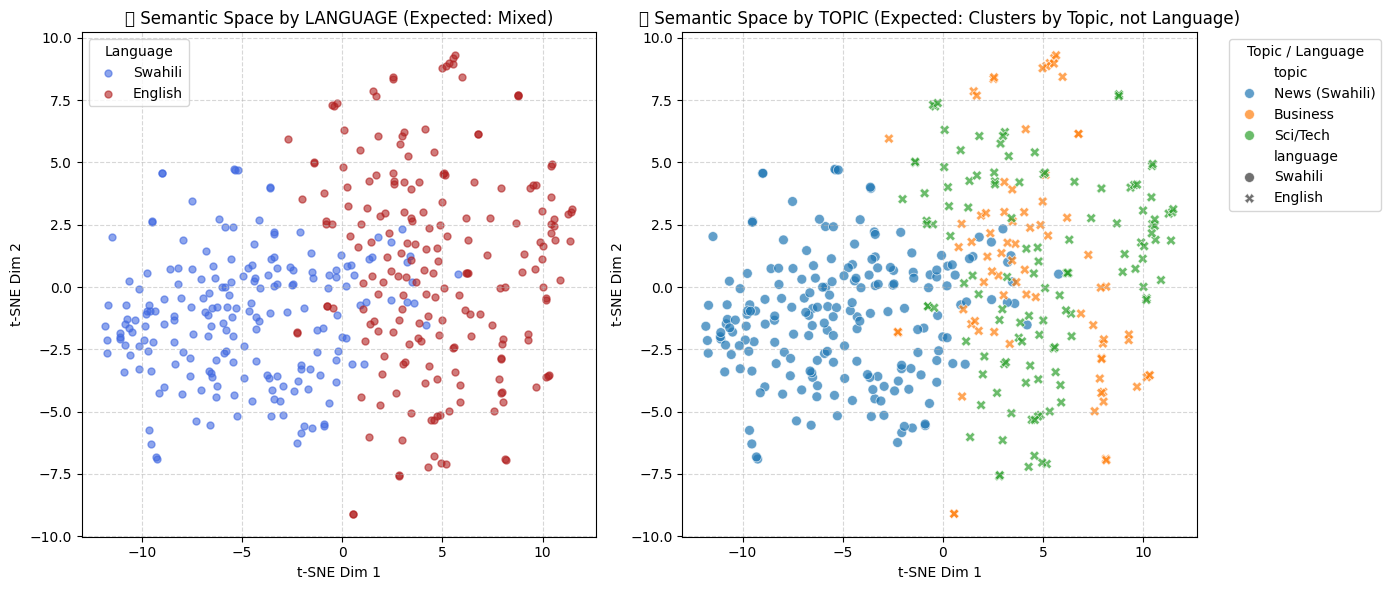


--- Simplified Step 24 Execution Complete ---


In [ ]:
# ======================================================================
# STEP 24: LANGUAGE-INVARIANT CLUSTERING (Simplified)
# FIX: Use the 'label' column and manually map AG News topics.
# ======================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Need this for the second plot
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE

# AG News Label Mapping
AG_NEWS_MAP = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

# 📚 Load small Swahili + English datasets
print("[INFO] Loading Swahili and English datasets...")
# Swahili news
sw = load_dataset("swahili_news", split="train[:200]")
# English news (AG News)
en = load_dataset("ag_news", split="train[:200]")

# Create DataFrames
sw_df = pd.DataFrame({
    "text": sw["text"],
    "language": "Swahili",
    "topic": "News (Swahili)" # Give Swahili a distinct topic name for the legend
})

# --- FIX APPLIED HERE: Use 'label' and map it ---
en_df = pd.DataFrame({
    "text": en["text"],
    "language": "English",
    "topic": [AG_NEWS_MAP[label] for label in en["label"]] # Map integer label to text
})

# Combine and show a sample
df = pd.concat([sw_df, en_df]).reset_index(drop=True)
print(f"Total samples loaded: {len(df)}")
print(df.sample(3))

# 🤖 Generate multilingual embeddings
print("\n[INFO] Generating multilingual embeddings...")
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(df["text"].tolist(), show_progress_bar=True, batch_size=32)

# 🔽 Reduce to 2-D (t-SNE)
print("\n[INFO] Reducing embeddings to 2D using t-SNE...")
# Increase perplexity slightly for better cluster separation if needed
tsne = TSNE(n_components=2, random_state=42, perplexity=40, learning_rate='auto', init='pca', n_jobs=-1)
reduced = tsne.fit_transform(embeddings)

df["x"], df["y"] = reduced[:,0], reduced[:,1]

# 🎨 Plot by language
print("\n[INFO] Generating Visualization...")
plt.figure(figsize=(14, 6))

# Plot 1: Color-coded by LANGUAGE (Expected: Mixed/Overlapping)
plt.subplot(1, 2, 1)
for lang, color in zip(["Swahili","English"], ["royalblue","firebrick"]):
    subset = df[df.language==lang]
    plt.scatter(subset.x, subset.y, label=lang, alpha=0.6, s=25, color=color)

plt.title("🌍 Semantic Space by LANGUAGE (Expected: Mixed)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title='Language')
plt.grid(True, linestyle='--', alpha=0.5)

# Plot 2: Color-coded by TOPIC (Expected: Clear Clusters)
plt.subplot(1, 2, 2)
# Using seaborn to leverage automatic color handling for topics
sns.scatterplot(x='x', y='y', hue='topic', data=df,
                palette='tab10', style='language', s=50, alpha=0.7)

plt.title("💡 Semantic Space by TOPIC (Expected: Clusters by Topic, not Language)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title='Topic / Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n--- Simplified Step 24 Execution Complete ---")